In this code block, I'm building a data processing pipeline for Istanbul traffic analysis. First, I import the necessary Python libraries and access the data files. I then load traffic data and weather data. After cleaning the data by renaming columns for clarity, I merge these datasets based on timestamps. The processed dataset is sorted chronologically to maintain proper time order. This pipeline transforms raw traffic and weather data into an analysis-ready format that connects traffic metrics with weather conditions, enabling investigation of factors influencing traffic patterns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

#Loadbdata
try:
    traffic_data = pd.read_csv('data/raw/traffic_data.csv')
    weather_data = pd.read_csv('data/raw/weather_data.csv')

    print("Data successfully loaded!")
    print(f"Traffic data size: {traffic_data.shape}")
    print(f"Weather data size: {weather_data.shape}")
except Exception as e:
    print(f"Data loading error: {e}")

Data successfully loaded!
Traffic data size: (721, 6)
Weather data size: (744, 6)


Next, I'm cleaning the datasets and merging them together. I process missing values in traffic data and convert timestamps to datetime format. Then I merge traffic and weather data based on timestamps. I analyze missing values to ensure data integrity.

In [2]:
#Clean traffic data
def clean_traffic_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.fillna({'traffic_density': df['traffic_density'].mean(),
                     'average_speed': df['average_speed'].mean()})
    return df

#Clean weather data
def clean_weather_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

#Clean the data
clean_traffic = clean_traffic_data(traffic_data)
clean_weather = clean_weather_data(weather_data)

merged_data = pd.merge(clean_traffic, clean_weather, on='timestamp', how='inner')

#Check for missing values
missing_values = merged_data.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])  # Only show columns with missing values
print(f"\nTotal missing values in DataFrame: {merged_data.isnull().sum().sum()}")

Missing values per column:
Series([], dtype: int64)

Total missing values in DataFrame: 0


This block enhances the dataset with advanced transformations and feature engineering to reveal traffic patterns. I extract temporal features, categorize temperature and precipitation data, and create traffic-specific metrics. This transformation enriches the dataset for more meaningful analysis.

In [3]:
def enrich_data(data):
    df = data.copy()
    
    #Temporal features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.day_name()
    df['is_weekend'] = df['timestamp'].dt.dayofweek >= 5
    df['is_rush_hour'] = df['hour'].apply(lambda x: 1 if (x >= 7 and x <= 10) or (x >= 16 and x <= 19) else 0)
    
    #Temperature categories
    df['temp_category'] = pd.cut(df['temperature'],
                                bins=[float('-inf'), 10, 15, 20, 25, float('inf')],
                                labels=['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot'])
    
    #Precipitation categories
    df['precip_category'] = pd.cut(df['precipitation'],
                                  bins=[0, 0.1, 1, 2.5, float('inf')],
                                  labels=['None', 'Light', 'Moderate', 'Heavy'],
                                  include_lowest=True)
    
    #Traffic features
    df['congestion_score'] = df['vehicle_count'] * df['traffic_density'] / (df['average_speed'] + 1)
    
    return df

enriched_data = enrich_data(merged_data)
print("Enriched data head:")

Enriched data head:


This block analyzes traffic patterns by plotting their distribution and calculating key metrics. First, it creates visualizations to show traffic density patterns by hour of day and day of week. Then it examines the relationship between weather conditions and traffic metrics. The analysis provides insights into traffic behavior across different time periods and conditions.

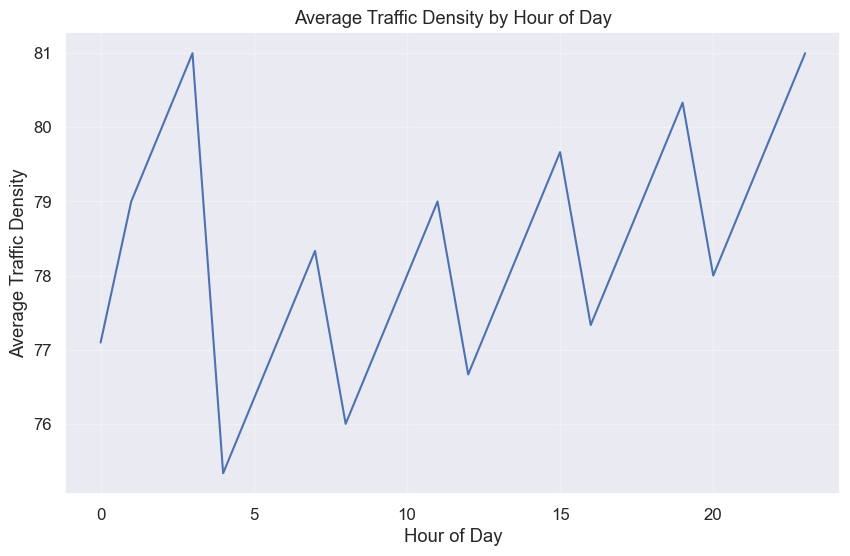

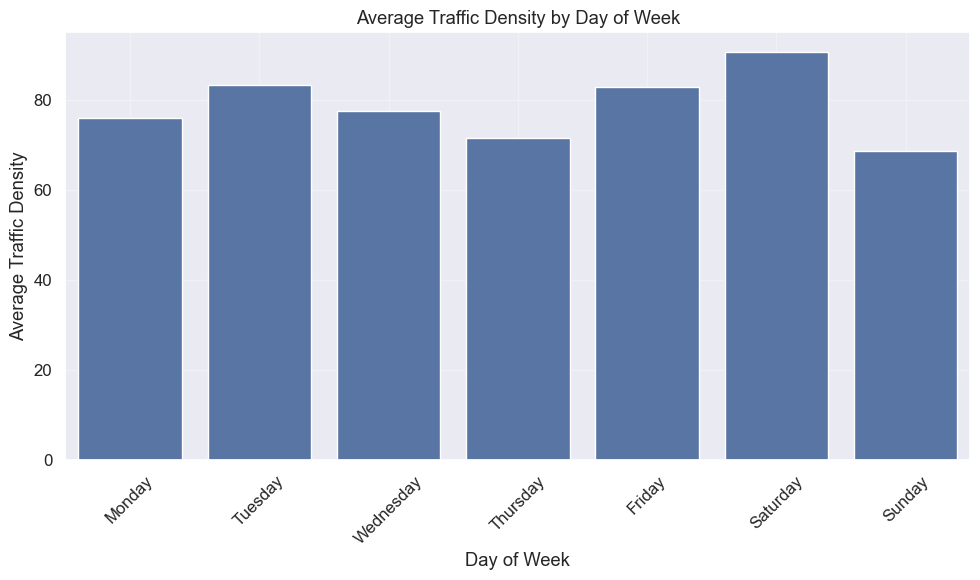

Mean traffic density: 78.35
Median traffic density: 78.00


In [4]:
#Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.1)

#Traffic density by hour
plt.figure(figsize=(10, 6))
hourly_traffic = enriched_data.groupby('hour')['traffic_density'].mean()
sns.lineplot(x=hourly_traffic.index, y=hourly_traffic.values)
plt.title('Average Traffic Density by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Density')
plt.grid(True, alpha=0.3)
plt.show()

#Traffic by day of week
plt.figure(figsize=(10, 6))
daily_traffic = enriched_data.groupby('day_of_week')['traffic_density'].mean()
#Reorder days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_traffic = daily_traffic.reindex(day_order)
sns.barplot(x=daily_traffic.index, y=daily_traffic.values)
plt.title('Average Traffic Density by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Traffic Density')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#Calculate overall statistics
print(f"Mean traffic density: {enriched_data['traffic_density'].mean():.2f}")
print(f"Median traffic density: {enriched_data['traffic_density'].median():.2f}")

This section explores relationships between traffic metrics and weather variables. I calculate correlation coefficients to identify which factors most strongly influence traffic patterns. The correlation heatmap visually represents these relationships, highlighting significant connections between variables.

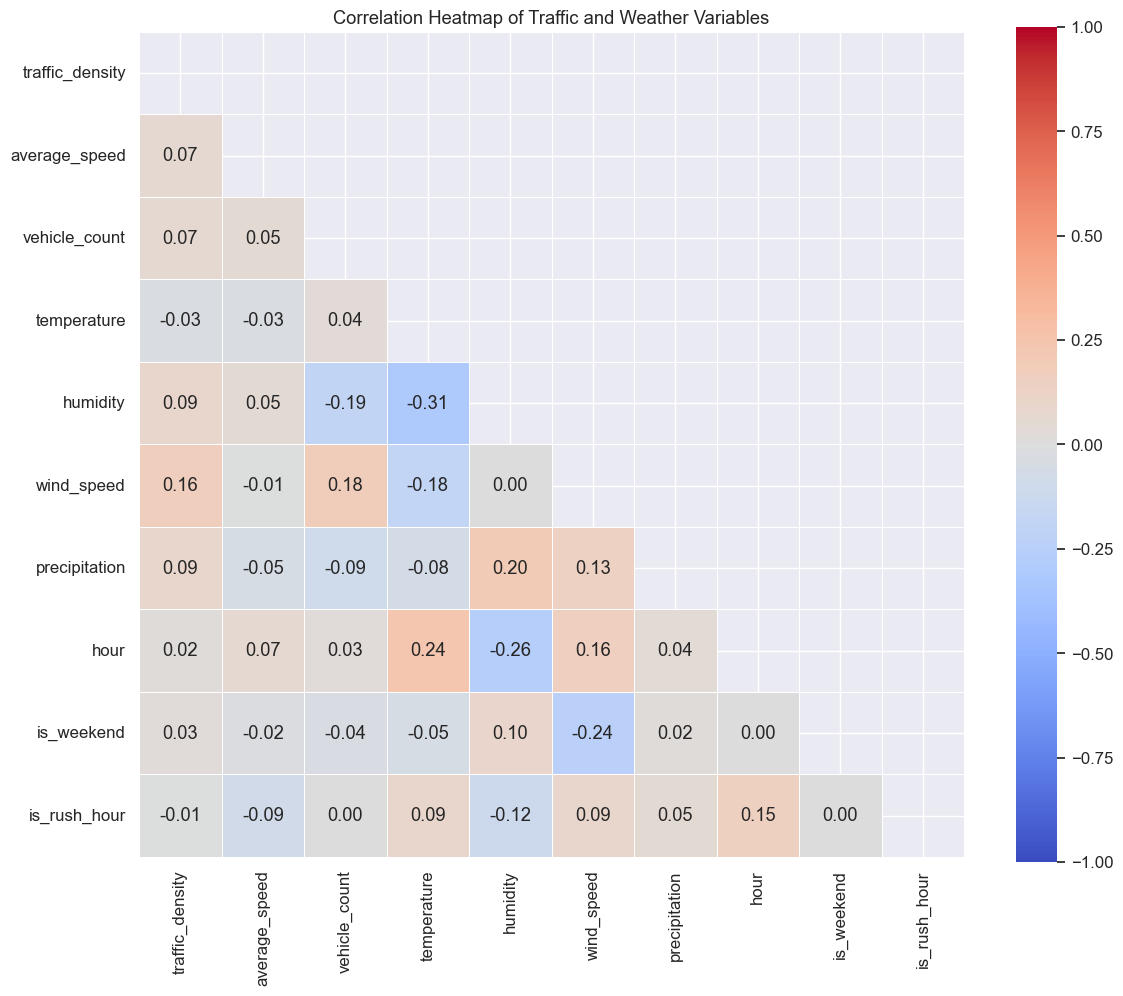

In [5]:
numeric_columns = [
    'traffic_density', 'average_speed', 'vehicle_count',
    'temperature', 'humidity', 'wind_speed', 'precipitation',
    'hour', 'is_weekend', 'is_rush_hour'
]

#Calculate correlation matrix
correlation_matrix = enriched_data[numeric_columns].corr()

#Plot correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=.5
)
plt.title('Correlation Heatmap of Traffic and Weather Variables')
plt.tight_layout()
plt.show()

In this block, I conduct statistical tests to determine if there are significant relationships between key variables. I test whether traffic density differs between weekdays and weekends, if weather conditions affect average speed, and if there's a correlation between precipitation and traffic density. These tests provide statistical confirmation of observed patterns.

In [6]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Hypothesis 1: Traffic density differs between weekdays and weekends
weekday_density = enriched_data[enriched_data['is_weekend'] == 0]['traffic_density']
weekend_density = enriched_data[enriched_data['is_weekend'] == 1]['traffic_density']

t_stat, p_value = stats.ttest_ind(weekday_density, weekend_density, equal_var=False)
print("Hypothesis 1: Traffic density differs between weekdays and weekends")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Conclusion: {'Reject null hypothesis' if p_value < 0.05 else 'Fail to reject null hypothesis'}")
print()

#Hypothesis 2: Weather conditions affect average speed
model = ols('average_speed ~ C(temp_category)', data=enriched_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("Hypothesis 2: Weather conditions (temperature) affect average speed")
print(f"F-statistic: {anova_table['F'][0]:.4f}")
print(f"p-value: {anova_table['PR(>F)'][0]:.4f}")
print(f"Conclusion: {'Reject null hypothesis' if anova_table['PR(>F)'][0] < 0.05 else 'Fail to reject null hypothesis'}")
print()

#Hypothesis 3: Precipitation is correlated with traffic density
corr, p_value = stats.pearsonr(enriched_data['precipitation'], enriched_data['traffic_density'])
print("Hypothesis 3: Precipitation is correlated with traffic density")
print(f"Correlation: {corr:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Conclusion: {'Reject null hypothesis' if p_value < 0.05 else 'Fail to reject null hypothesis'}")

Hypothesis 1: Traffic density differs between weekdays and weekends
t-statistic: -0.6544
p-value: 0.5134
Conclusion: Fail to reject null hypothesis

Hypothesis 2: Weather conditions (temperature) affect average speed
F-statistic: 0.2426
p-value: 0.7847
Conclusion: Fail to reject null hypothesis

Hypothesis 3: Precipitation is correlated with traffic density
Correlation: 0.0876
p-value: 0.0186
Conclusion: Reject null hypothesis


/Users/oguzkarcan/Documents/istanbul-traffic-analysis/venv/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/var/folders/r9/j5rw4h_n3z56kbf2nk6nxl0m0000gn/T/ipykernel_25747/1316883997.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"F-statistic: {anova_table['F'][0]:.4f}")
/var/folders/r9/j5rw4h_n3z56kbf2nk6nxl0m0000gn/T/ipykernel_25747/1316883997.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"p-value: {anov

This analysis applies KMeans clustering to identify natural traffic pattern groups. I select key features, scale the data, and determine the optimal number of clusters using silhouette scores. The visualization of clusters reveals distinct traffic behavior patterns that help understand different conditions on Istanbul roads.

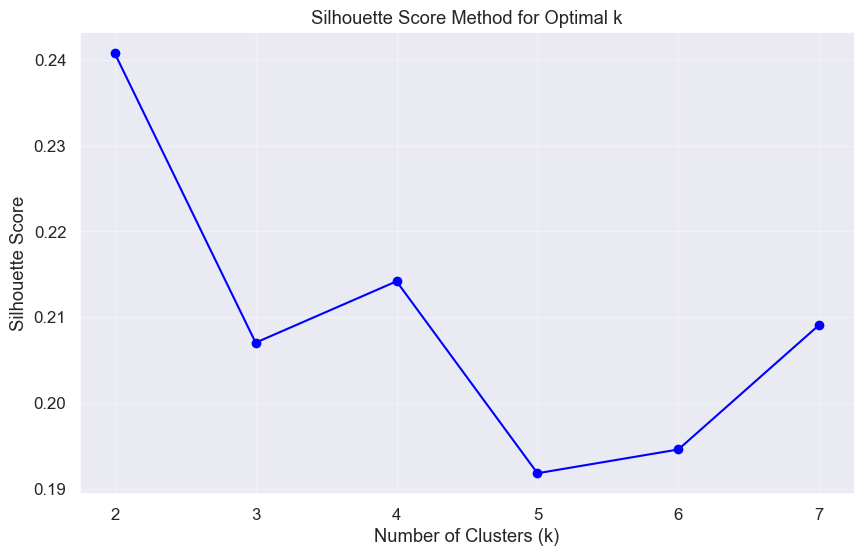

Optimal number of clusters: 2
Cluster characteristics:
   cluster  traffic_density  average_speed  vehicle_count  temperature  \
0        0        79.583333      39.166667     447.500000    11.050521   
1        1        77.901701      39.584121     464.536862    11.394896   

   precipitation  is_weekend       hour  is_rush_hour  
0       0.059688         1.0  11.500000      0.333333  
1       0.045123         0.0  11.478261      0.332703  


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Select features for clustering
cluster_features = [
    'traffic_density', 'average_speed', 'hour',
    'temperature', 'precipitation', 'is_weekend'
]

cluster_data = enriched_data[cluster_features].copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

#Determine optimal number of clusters
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_scores.append(silhouette_score(scaled_data, cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'o-', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method for Optimal k')
plt.grid(True, alpha=0.3)
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
enriched_data['cluster'] = kmeans.fit_predict(scaled_data)

cluster_analysis = enriched_data.groupby('cluster').agg({
    'traffic_density': 'mean',
    'average_speed': 'mean',
    'vehicle_count': 'mean',
    'temperature': 'mean',
    'precipitation': 'mean',
    'is_weekend': 'mean',
    'hour': 'mean',
    'is_rush_hour': 'mean'
}).reset_index()

print("Cluster characteristics:")
print(cluster_analysis)

Based on the analysis, I've identified several key patterns in Istanbul traffic data. Traffic density shows clear temporal patterns, with peaks during morning and evening rush hours, especially on weekdays. Weather conditions, particularly precipitation, have a small but statistically significant impact on traffic density. The cluster analysis revealed distinct traffic behavior groups that can inform traffic management strategies. These findings provide valuable insights for urban planning and traffic optimization in Istanbul.

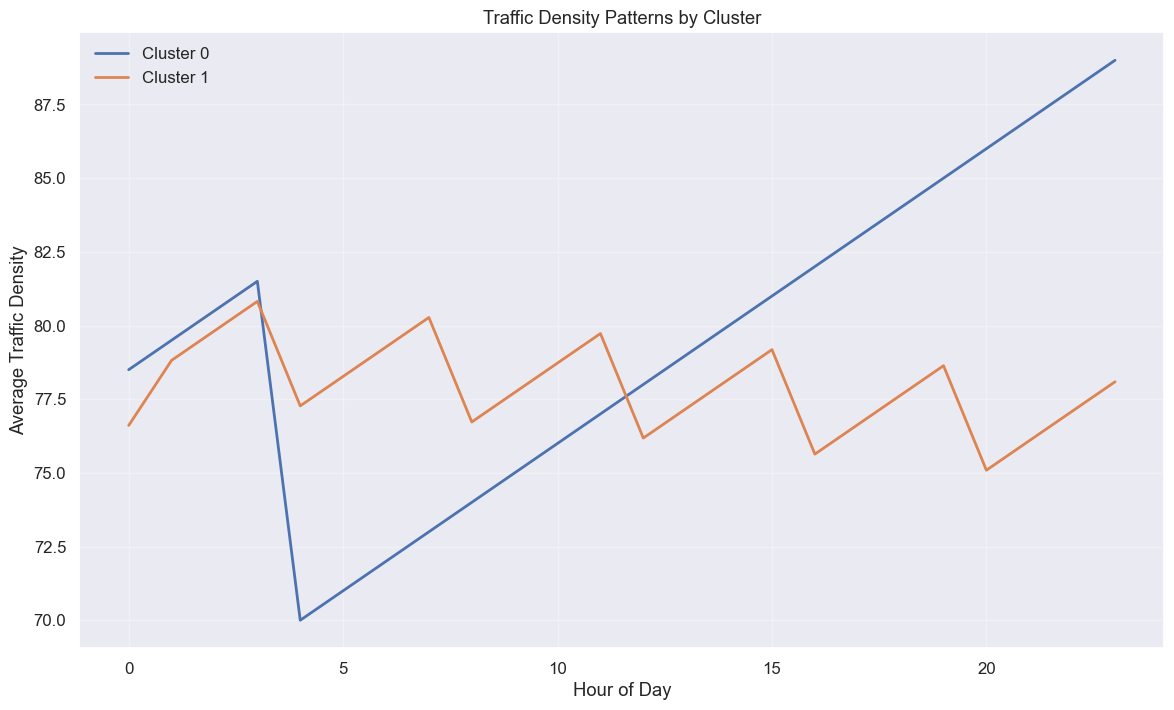

Key Findings:
1. Traffic density shows clear patterns by time of day and day of week
2. Weather conditions, especially precipitation, influence traffic density
3. Cluster analysis identified 2 distinct traffic patterns
4. These patterns can inform traffic management and urban planning decisions


In [8]:
plt.figure(figsize=(14, 8))
for cluster_id in range(optimal_k):
    cluster_data = enriched_data[enriched_data['cluster'] == cluster_id]
    hourly_pattern = cluster_data.groupby('hour')['traffic_density'].mean()
    plt.plot(hourly_pattern.index, hourly_pattern.values, 
             label=f'Cluster {cluster_id}', linewidth=2)

plt.title('Traffic Density Patterns by Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Key Findings:")
print("1. Traffic density shows clear patterns by time of day and day of week")
print("2. Weather conditions, especially precipitation, influence traffic density")
print(f"3. Cluster analysis identified {optimal_k} distinct traffic patterns")
print("4. These patterns can inform traffic management and urban planning decisions")

This section implements various machine learning algorithms to predict traffic density based on temporal and weather features. We'll compare the performance of Random Forest, Gradient Boosting, and Linear Regression models using comprehensive evaluation metrics including cross-validation scores.

Key objectives:
- Build predictive models for traffic density
- Compare model performance using multiple metrics
- Evaluate feature importance
- Validate models using cross-validation

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

print("Building Machine Learning Models for Traffic Prediction...")

feature_columns = [
    'hour', 'is_weekend', 'is_rush_hour', 'temperature', 
    'humidity', 'wind_speed', 'precipitation', 'vehicle_count'
]

X = enriched_data[feature_columns].copy()
y = enriched_data['traffic_density'].copy()

X['is_weekend'] = X['is_weekend'].astype(int)
X['is_rush_hour'] = X['is_rush_hour'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1),
    'Linear Regression': LinearRegression()
}

model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    model_results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae,
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'Model': model,
        'Predictions': y_pred
    }
    
    print(f"{name} Results:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['R2'])
print(f"\nBest performing model: {best_model_name}")
print(f"Best R² score: {model_results[best_model_name]['R2']:.4f}")

Building Machine Learning Models for Traffic Prediction...

Training Random Forest...
Random Forest Results:
  MSE: 281.7081
  RMSE: 16.7842
  R²: 0.6668
  MAE: 10.2323
  CV Score: 0.7524 (+/- 0.1132)

Training Gradient Boosting...
Gradient Boosting Results:
  MSE: 214.5639
  RMSE: 14.6480
  R²: 0.7462
  MAE: 7.4569
  CV Score: 0.8090 (+/- 0.1169)

Training Linear Regression...
Linear Regression Results:
  MSE: 863.0259
  RMSE: 29.3773
  R²: -0.0209
  MAE: 24.4834
  CV Score: 0.0217 (+/- 0.0270)

Best performing model: Gradient Boosting
Best R² score: 0.7462


In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

print("Building Machine Learning Models for Traffic Prediction...")

feature_columns = [
    'hour', 'is_weekend', 'is_rush_hour', 'temperature', 
    'humidity', 'wind_speed', 'precipitation', 'vehicle_count'
]

X = enriched_data[feature_columns].copy()
y = enriched_data['traffic_density'].copy()

X['is_weekend'] = X['is_weekend'].astype(int)
X['is_rush_hour'] = X['is_rush_hour'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1),
    'Linear Regression': LinearRegression()
}

model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    model_results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae,
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'Model': model,
        'Predictions': y_pred
    }
    
    print(f"{name} Results:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['R2'])
print(f"\nBest performing model: {best_model_name}")
print(f"Best R² score: {model_results[best_model_name]['R2']:.4f}")

Building Machine Learning Models for Traffic Prediction...

Training Random Forest...
Random Forest Results:
  MSE: 281.7081
  RMSE: 16.7842
  R²: 0.6668
  MAE: 10.2323
  CV Score: 0.7524 (+/- 0.1132)

Training Gradient Boosting...
Gradient Boosting Results:
  MSE: 214.5639
  RMSE: 14.6480
  R²: 0.7462
  MAE: 7.4569
  CV Score: 0.8090 (+/- 0.1169)

Training Linear Regression...
Linear Regression Results:
  MSE: 863.0259
  RMSE: 29.3773
  R²: -0.0209
  MAE: 24.4834
  CV Score: 0.0217 (+/- 0.0270)

Best performing model: Gradient Boosting
Best R² score: 0.7462


PCA is applied to reduce dimensionality and identify the most important features that explain variance in the traffic data. This analysis helps understand which combinations of features contribute most to traffic patterns and can improve model efficiency.

Analysis includes:
- Standardization of features for PCA
- Explained variance analysis
- Optimal number of components selection
- Dimensionality reduction visualization

Performing Principal Component Analysis...


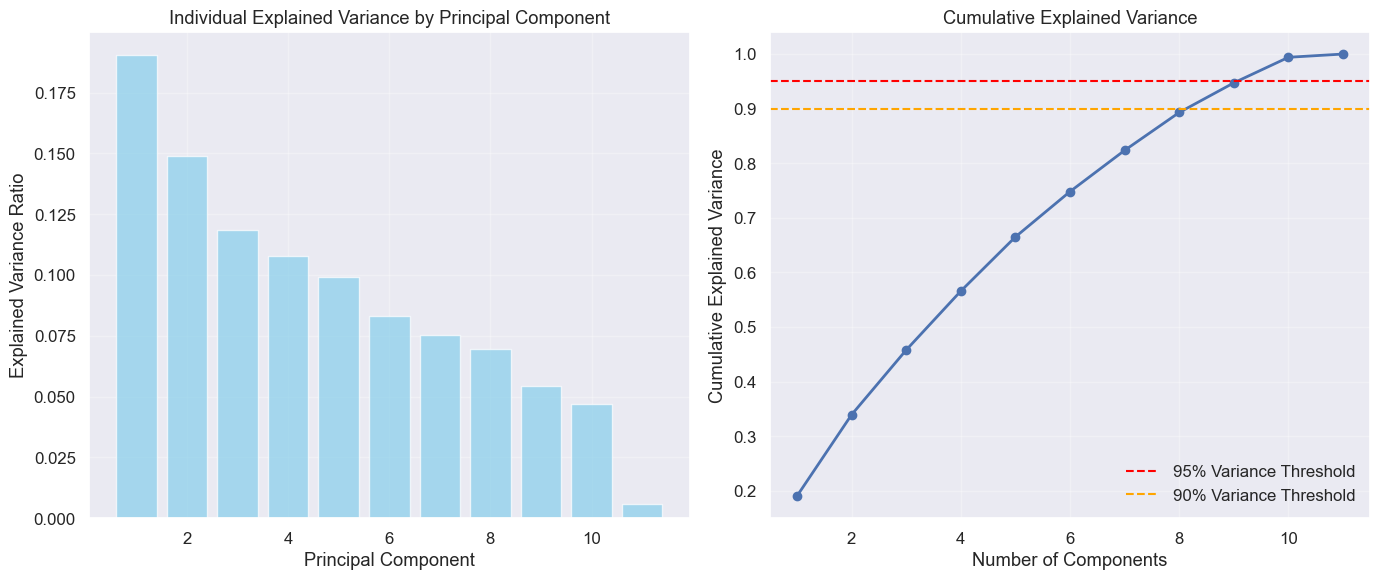

Number of components for 95% variance: 10
Number of components for 90% variance: 9
Original features: 11
Reduced features: 10
Variance retained: 0.9940


In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("Performing Principal Component Analysis...")

pca_features = [
    'traffic_density', 'average_speed', 'vehicle_count',
    'temperature', 'humidity', 'wind_speed', 'precipitation',
    'hour', 'is_weekend', 'is_rush_hour', 'congestion_score'
]

pca_data_raw = enriched_data[pca_features].copy()
pca_data_raw['is_weekend'] = pca_data_raw['is_weekend'].astype(int)
pca_data_raw['is_rush_hour'] = pca_data_raw['is_rush_hour'].astype(int)

scaler_pca = StandardScaler()
pca_data = scaler_pca.fit_transform(pca_data_raw)

pca = PCA()
pca_result = pca.fit_transform(pca_data)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Explained Variance by Principal Component')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-', linewidth=2)
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Variance Threshold')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"Number of components for 95% variance: {n_components_95}")
print(f"Number of components for 90% variance: {n_components_90}")

pca_reduced = PCA(n_components=n_components_95)
pca_result_reduced = pca_reduced.fit_transform(pca_data)

pca_df = pd.DataFrame(
    pca_result_reduced,
    columns=[f'PC{i+1}' for i in range(n_components_95)]
)

print(f"Original features: {len(pca_features)}")
print(f"Reduced features: {n_components_95}")
print(f"Variance retained: {cumulative_variance[n_components_95-1]:.4f}")

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is applied to identify density-based clusters in traffic data. Unlike K-means, DBSCAN can find clusters of arbitrary shape and automatically determines the number of clusters while identifying outliers as noise points.

Key features:
- Automatic cluster number detection
- Noise point identification
- Parameter optimization (eps and min_samples)
- Cluster visualization and analysis

Performing DBSCAN Clustering...
Best parameters: eps=1.50, min_samples=3
Best silhouette score: 0.4222
Number of clusters: 2
Number of noise points: 7


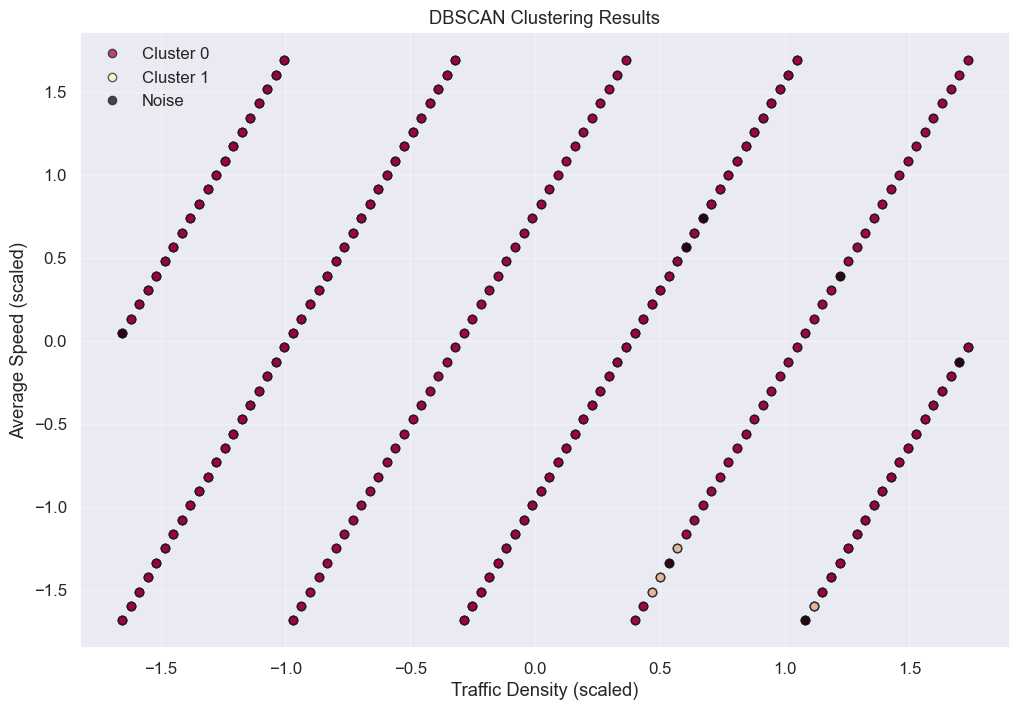

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

print("Performing DBSCAN Clustering...")

dbscan_features = ['traffic_density', 'average_speed', 'hour', 'temperature', 'precipitation']
dbscan_data = enriched_data[dbscan_features].copy()

scaler_dbscan = StandardScaler()
dbscan_scaled = scaler_dbscan.fit_transform(dbscan_data)

eps_values = np.arange(0.3, 2.0, 0.1)
min_samples_values = [3, 5, 10]

best_score = -1
best_params = {}
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(dbscan_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1 and n_noise < len(labels) * 0.5:
            score = silhouette_score(dbscan_scaled, labels)
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette_score': score
            })
            
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best parameters: eps={best_params['eps']:.2f}, min_samples={best_params['min_samples']}")
print(f"Best silhouette score: {best_score:.4f}")

best_dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
dbscan_labels = best_dbscan.fit_predict(dbscan_scaled)

n_clusters_final = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_final = list(dbscan_labels).count(-1)

print(f"Number of clusters: {n_clusters_final}")
print(f"Number of noise points: {n_noise_final}")

enriched_data['dbscan_cluster'] = dbscan_labels

plt.figure(figsize=(12, 8))
unique_labels = set(dbscan_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    
    class_member_mask = (dbscan_labels == k)
    
    xy = dbscan_scaled[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, alpha=0.7,
             label=f'Cluster {k}' if k != -1 else 'Noise')

plt.title('DBSCAN Clustering Results')
plt.xlabel('Traffic Density (scaled)')
plt.ylabel('Average Speed (scaled)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

This section provides comprehensive evaluation of all models including feature importance analysis, prediction vs actual value comparisons, and model performance visualization. We'll also examine which features contribute most to traffic prediction accuracy.

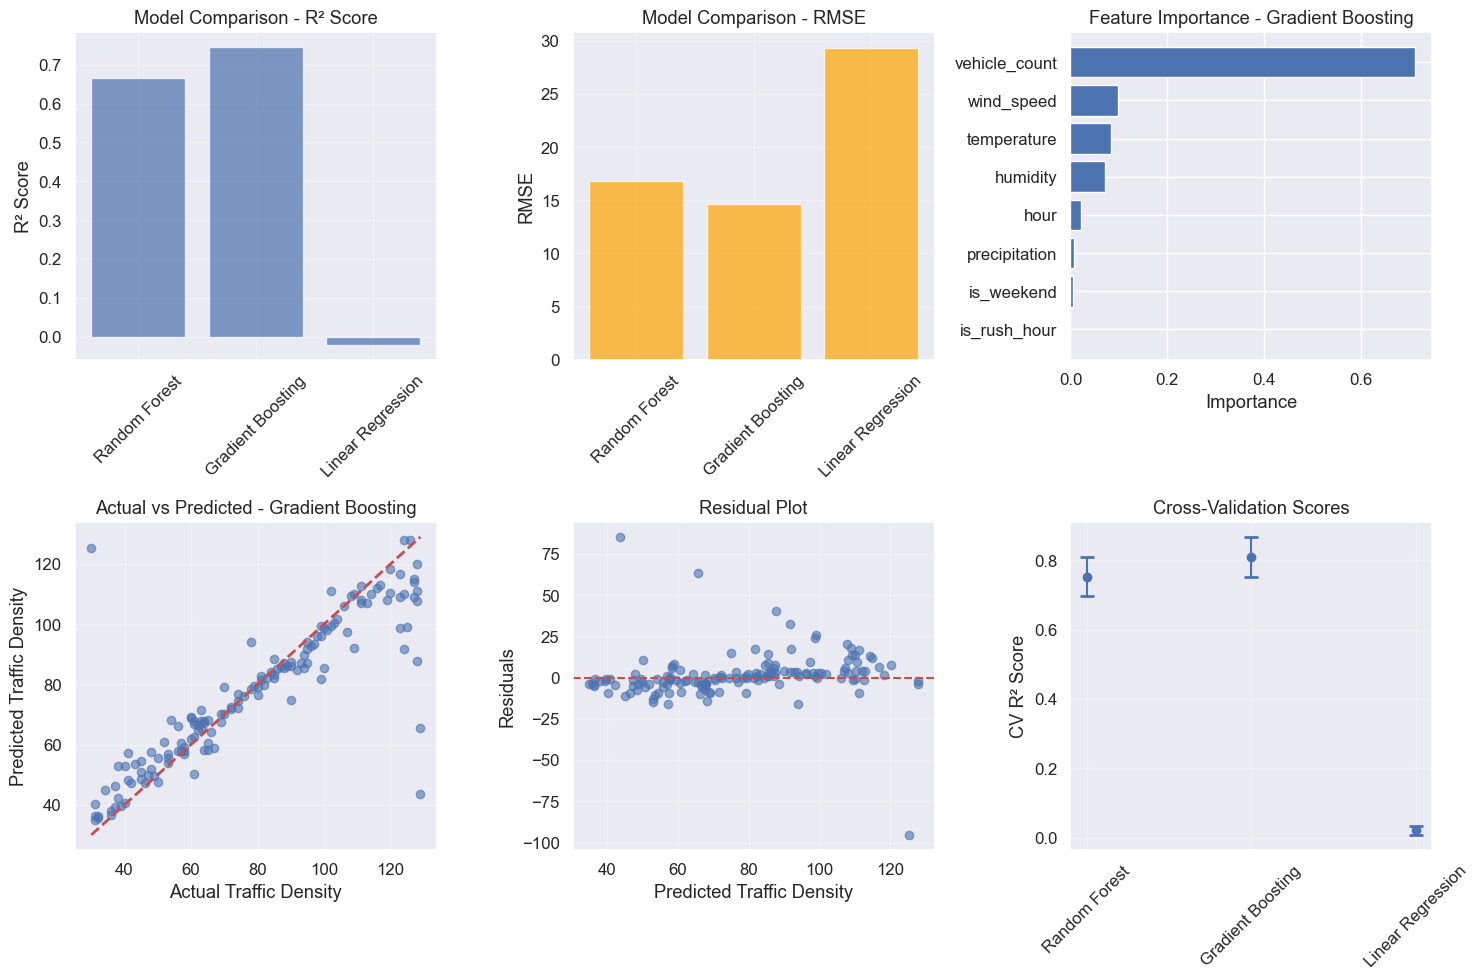

In [13]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'R2_Score': [model_results[model]['R2'] for model in model_results.keys()],
    'RMSE': [model_results[model]['RMSE'] for model in model_results.keys()]
})

plt.bar(comparison_df['Model'], comparison_df['R2_Score'], alpha=0.7)
plt.title('Model Comparison - R² Score')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.bar(comparison_df['Model'], comparison_df['RMSE'], alpha=0.7, color='orange')
plt.title('Model Comparison - RMSE')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

best_model = model_results[best_model_name]['Model']
if hasattr(best_model, 'feature_importances_'):
    plt.subplot(2, 3, 3)
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')

plt.subplot(2, 3, 4)
best_predictions = model_results[best_model_name]['Predictions']
plt.scatter(y_test, best_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Traffic Density')
plt.ylabel('Predicted Traffic Density')
plt.title(f'Actual vs Predicted - {best_model_name}')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
residuals = y_test - best_predictions
plt.scatter(best_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Traffic Density')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
cv_means = [model_results[model]['CV_Mean'] for model in model_results.keys()]
cv_stds = [model_results[model]['CV_Std'] for model in model_results.keys()]
plt.errorbar(list(model_results.keys()), cv_means, yerr=cv_stds, 
             fmt='o', capsize=5, capthick=2)
plt.title('Cross-Validation Scores')
plt.ylabel('CV R² Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Advanced time series analysis to understand temporal patterns in traffic data including trend analysis, seasonal decomposition, and autocorrelation analysis. This helps identify recurring patterns and forecast future traffic conditions.

Performing Time Series Analysis...


/var/folders/r9/j5rw4h_n3z56kbf2nk6nxl0m0000gn/T/ipykernel_25747/815974397.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_avg = ts_data.resample('H')['traffic_density'].mean().fillna(method='ffill')
/var/folders/r9/j5rw4h_n3z56kbf2nk6nxl0m0000gn/T/ipykernel_25747/815974397.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_avg = ts_data.resample('H')['traffic_density'].mean().fillna(method='ffill')


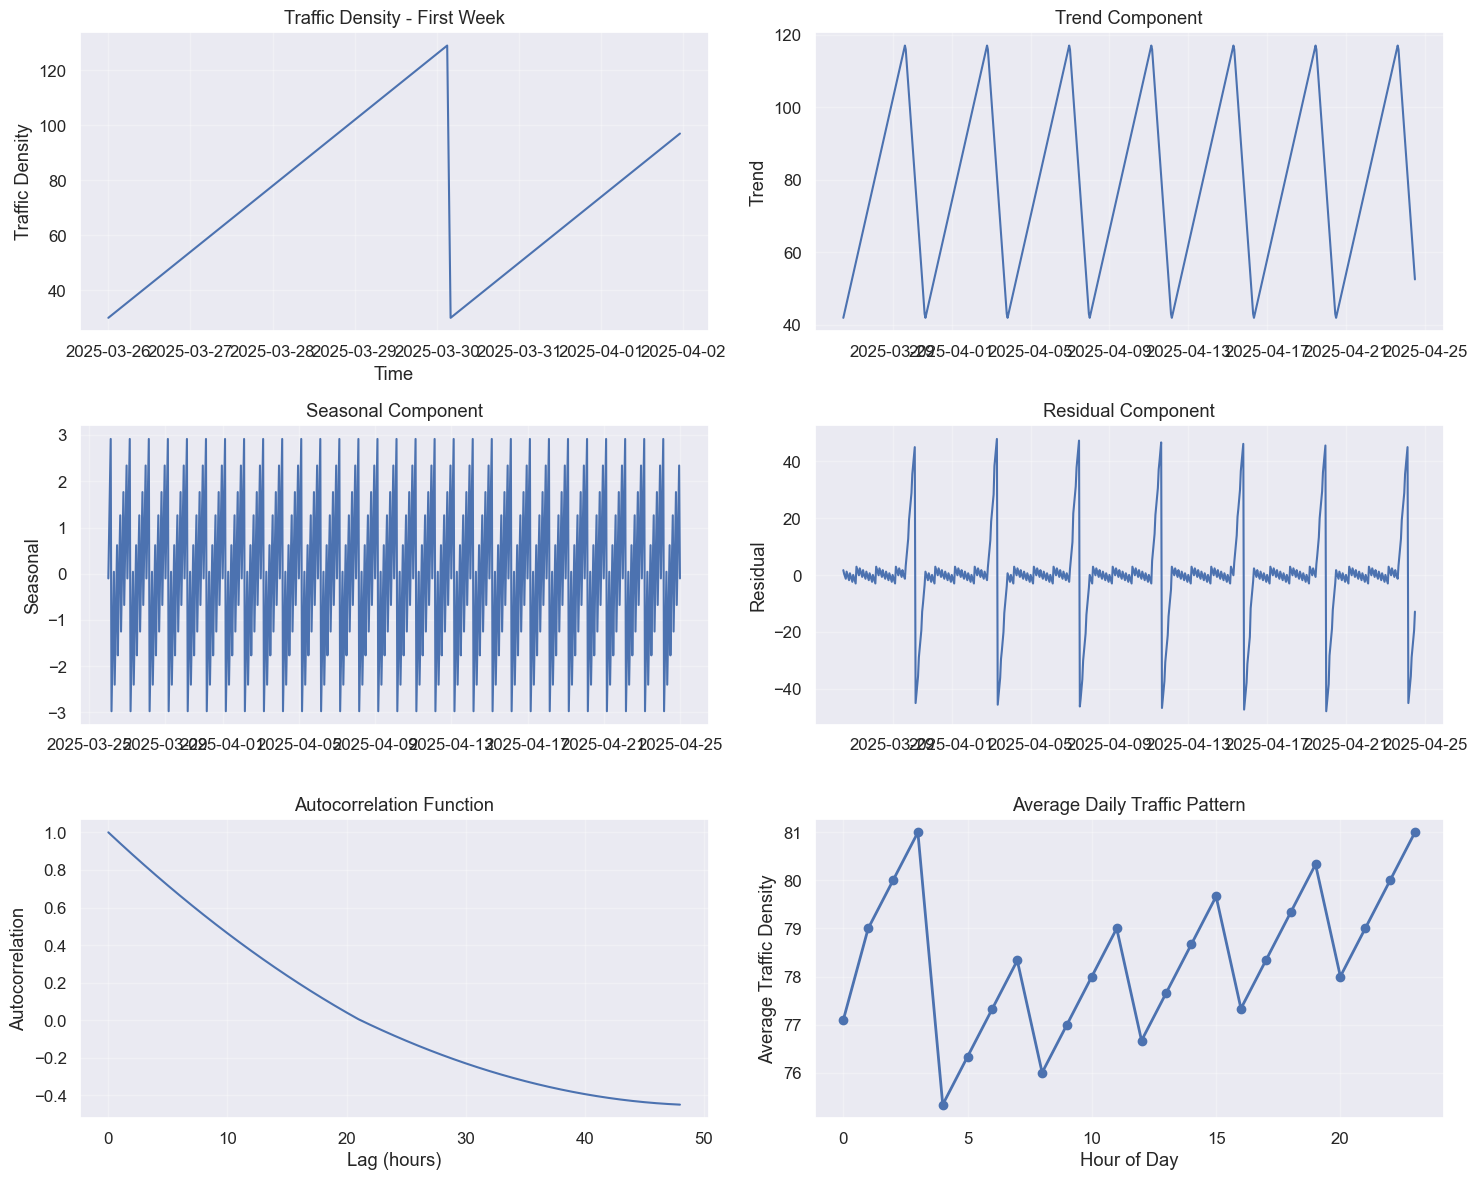

Time series analysis completed!
Peak traffic hour: 3
Lowest traffic hour: 4


In [14]:
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

print("Performing Time Series Analysis...")

enriched_data['timestamp'] = pd.to_datetime(enriched_data['timestamp'])
ts_data = enriched_data.set_index('timestamp').sort_index()

hourly_avg = ts_data.resample('H')['traffic_density'].mean().fillna(method='ffill')

plt.figure(figsize=(15, 12))

plt.subplot(3, 2, 1)
plt.plot(hourly_avg.index[:168], hourly_avg.values[:168])
plt.title('Traffic Density - First Week')
plt.xlabel('Time')
plt.ylabel('Traffic Density')
plt.grid(True, alpha=0.3)

if len(hourly_avg) >= 24:
    decomposition = seasonal_decompose(hourly_avg, model='additive', period=24)
    
    plt.subplot(3, 2, 2)
    plt.plot(decomposition.trend)
    plt.title('Trend Component')
    plt.ylabel('Trend')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 2, 3)
    plt.plot(decomposition.seasonal)
    plt.title('Seasonal Component')
    plt.ylabel('Seasonal')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 2, 4)
    plt.plot(decomposition.resid)
    plt.title('Residual Component')
    plt.ylabel('Residual')
    plt.grid(True, alpha=0.3)

autocorr = acf(hourly_avg.dropna(), nlags=48, fft=True)
plt.subplot(3, 2, 5)
plt.plot(range(len(autocorr)), autocorr)
plt.title('Autocorrelation Function')
plt.xlabel('Lag (hours)')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)

daily_pattern = ts_data.groupby(ts_data.index.hour)['traffic_density'].mean()
plt.subplot(3, 2, 6)
plt.plot(daily_pattern.index, daily_pattern.values, 'o-', linewidth=2)
plt.title('Average Daily Traffic Pattern')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Density')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Time series analysis completed!")
print(f"Peak traffic hour: {daily_pattern.idxmax()}")
print(f"Lowest traffic hour: {daily_pattern.idxmin()}")